In [1]:
import torch
import torchvision
import os
import random

import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image

from transformers import BeitForImageClassification, BeitConfig, BeitFeatureExtractor, Trainer, TrainingArguments
from PIL import Image

from tqdm import tqdm
from collections import defaultdict

In [2]:
# Check for GPU
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

device

'cuda:0'

In [3]:
class food_set(Dataset):

    def __init__(self, labels_file, img_dir, extractor, transform = None, settype = "train"):
        if settype == "train":
            self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[:30000]
        elif settype == "val":
            self.img_labels = pd.read_csv(labels_file, names=['img_name', 'label'], header=1)[30000:]
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
                
        features = self.feature_extractor(images=image, 
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])["pixel_values"][0]
        label = self.img_labels.iloc[idx, 1]       
            
        return features, label

In [4]:
class food_test(Dataset):

    def __init__(self, img_dir, extractor):
        self.img_dir = img_dir
        self.feature_extractor = extractor
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.img_dir))

    def __getitem__(self, idx):
        file_name = os.listdir(self.img_dir)[idx]
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path)
        
        features = self.feature_extractor(images=image, 
                                          mean=[0.485, 0.456, 0.406],
                                          std=[0.229, 0.224, 0.225])["pixel_values"][0]
        
        return file_name, features

In [5]:
# Load BEiT
beit = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")

beit.classifier = torch.nn.Linear(768, 81)

D:\ProgramData\Anaconda3\envs\R + Python\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
def train_loop(trainloader, valloader, model, criterion, optimizer, labels, 
               img_dir, feature_extractor = None, transform = None):
    
    
    # Train on GPU if available
    model = model.to(device)
    model.train()
    
    # Metadata
    stats = defaultdict(list)
    current_acc = 0
    max_acc = 0
    
    try:
        stats["epoch"].append(0)
        stats["loss"].append(8.7)
        stats["accuracy"].append(1.25)

        size = len(trainloader.dataset)
        
        for epoch in range(10):        
            for batch, (image, label) in enumerate(trainloader):
                # Compute prediction and loss
                image, label = image.to(device), label.to(device)            
                pred = model(image)
                loss = criterion(pred["logits"], label)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Print progress
                if batch % 200 == 0:
                    loss, current = loss.item(), batch * len(image)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}] epoch: {epoch + 1}")

            # Print performance after current number of epochs
            print(f"Epoch: {epoch + 1}")
            current_acc, avg_loss = test_loop(valloader, model, criterion)

            if current_acc > max_acc:
                PATH = f'../../beit_data_augmented.pth'
                torch.save(beit.state_dict(), PATH)
                max_acc = current_acc

            # Store metadata
            stats["epoch"].append(epoch + 1)
            stats["accuracy"].append(current_acc)
            stats["loss"].append(avg_loss)

            # Plot progress
            fig, ax1 = plt.subplots()

            color = "tab:blue"
            ax1.set_xlabel("Epoch")
            ax1.set_ylabel("Loss", color=color)
            ax1.plot(stats["epoch"], stats["loss"], color=color)
            ax1.tick_params(axis="y", labelcolor=color)

            ax2 = ax1.twinx()

            color = "tab:orange"
            ax2.set_ylabel("Accuracy", color=color)
            ax2.plot(stats["epoch"], stats["accuracy"], color=color)
            ax2.tick_params(axis="y", labelcolor=color)
            plt.show()

        return stats
    
    except KeyboardInterrupt:
        return stats


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            test_loss += criterion(pred["logits"], label).item()
            correct += (pred["logits"].argmax(1) == label).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100 * correct), test_loss

In [7]:
# CrossEntropyLoss and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(beit.parameters(), lr = 0.001, momentum = 0.9)
# optimizer = optim.Adam(beit.parameters(), lr=1e-3, weight_decay=1e-5)

In [8]:
img_dir = "../data/train_set/train_set"
labels = "../data/train_labels.csv"

transform = transforms.Compose(
                    [transforms.RandomApply([transforms.ColorJitter()]),
                     transforms.RandomApply([transforms.RandomAffine(180)]),
                     transforms.RandomHorizontalFlip()])

feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")

In [9]:
trainset = food_set(labels, img_dir, feature_extractor, transform = transform, settype = "train")
valset = food_set(labels, img_dir, feature_extractor, settype = "val")

# Create a DataLoader with the data
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=16, shuffle=True, num_workers=0)

In [10]:
test_set = food_test("../data/test_set/test_set", feature_extractor)
testloader = DataLoader(test_set, batch_size = 16)

len(test_set)

7653

loss: 4.813168  [    0/30000] epoch: 1
loss: 4.501013  [ 3200/30000] epoch: 1
loss: 4.451943  [ 6400/30000] epoch: 1
loss: 4.395232  [ 9600/30000] epoch: 1
loss: 4.070030  [12800/30000] epoch: 1
loss: 3.982871  [16000/30000] epoch: 1
loss: 3.764571  [19200/30000] epoch: 1
loss: 3.311432  [22400/30000] epoch: 1
loss: 3.817529  [25600/30000] epoch: 1
loss: 3.110253  [28800/30000] epoch: 1
Epoch: 1
Test Error: 
 Accuracy: 16.4%, Avg loss: 3.467977 



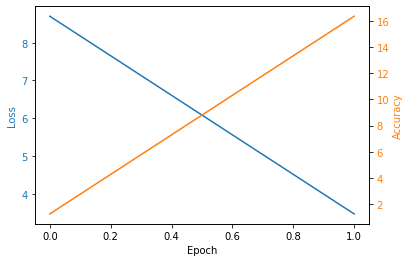

loss: 3.313221  [    0/30000] epoch: 2
loss: 2.029700  [ 3200/30000] epoch: 2
loss: 1.888059  [ 6400/30000] epoch: 2
loss: 2.458140  [ 9600/30000] epoch: 2
loss: 1.833127  [12800/30000] epoch: 2
loss: 1.955285  [16000/30000] epoch: 2
loss: 1.521407  [19200/30000] epoch: 2
loss: 1.277637  [22400/30000] epoch: 2
loss: 3.602673  [25600/30000] epoch: 2
loss: 1.423982  [28800/30000] epoch: 2
Epoch: 2
Test Error: 
 Accuracy: 60.9%, Avg loss: 1.534516 



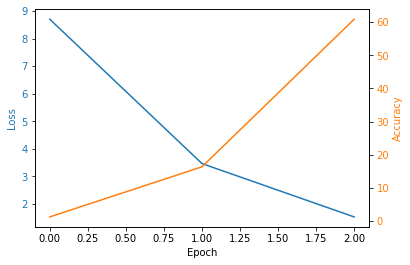

loss: 1.273202  [    0/30000] epoch: 3
loss: 0.844850  [ 3200/30000] epoch: 3
loss: 1.592337  [ 6400/30000] epoch: 3
loss: 1.127628  [ 9600/30000] epoch: 3
loss: 1.065105  [12800/30000] epoch: 3
loss: 0.783884  [16000/30000] epoch: 3
loss: 1.452652  [19200/30000] epoch: 3
loss: 0.948038  [22400/30000] epoch: 3
loss: 0.869056  [25600/30000] epoch: 3
loss: 0.681047  [28800/30000] epoch: 3
Epoch: 3
Test Error: 
 Accuracy: 68.6%, Avg loss: 1.196034 



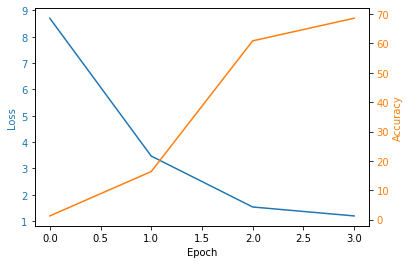

loss: 1.070178  [    0/30000] epoch: 4
loss: 1.309582  [ 3200/30000] epoch: 4
loss: 0.784375  [ 6400/30000] epoch: 4
loss: 1.030711  [ 9600/30000] epoch: 4
loss: 1.908956  [12800/30000] epoch: 4
loss: 1.474650  [16000/30000] epoch: 4
loss: 1.528397  [19200/30000] epoch: 4
loss: 1.124508  [22400/30000] epoch: 4
loss: 0.698527  [25600/30000] epoch: 4
loss: 0.949709  [28800/30000] epoch: 4
Epoch: 4
Test Error: 
 Accuracy: 69.2%, Avg loss: 1.082875 



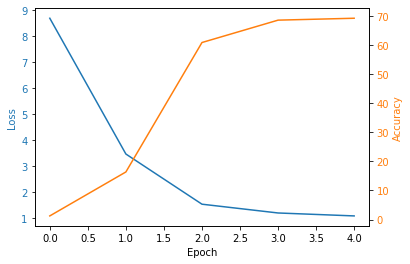

loss: 0.876473  [    0/30000] epoch: 5
loss: 1.099922  [ 3200/30000] epoch: 5
loss: 0.967207  [ 6400/30000] epoch: 5
loss: 0.709785  [ 9600/30000] epoch: 5
loss: 1.141645  [12800/30000] epoch: 5
loss: 0.230486  [16000/30000] epoch: 5
loss: 0.668720  [19200/30000] epoch: 5
loss: 0.788236  [22400/30000] epoch: 5
loss: 0.842149  [25600/30000] epoch: 5
loss: 0.798886  [28800/30000] epoch: 5
Epoch: 5
Test Error: 
 Accuracy: 72.0%, Avg loss: 1.003320 



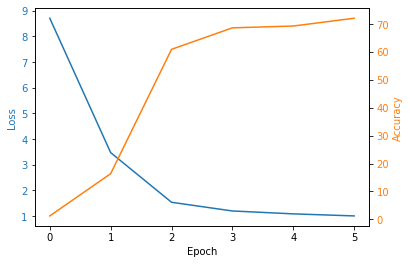

loss: 0.345225  [    0/30000] epoch: 6
loss: 0.457001  [ 3200/30000] epoch: 6
loss: 0.575557  [ 6400/30000] epoch: 6
loss: 1.351625  [ 9600/30000] epoch: 6
loss: 0.307732  [12800/30000] epoch: 6
loss: 0.515137  [16000/30000] epoch: 6
loss: 0.582713  [19200/30000] epoch: 6
loss: 0.573152  [22400/30000] epoch: 6
loss: 1.100282  [25600/30000] epoch: 6
loss: 0.776443  [28800/30000] epoch: 6
Epoch: 6
Test Error: 
 Accuracy: 73.5%, Avg loss: 0.990284 



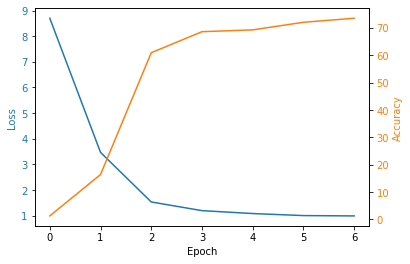

loss: 0.632786  [    0/30000] epoch: 7
loss: 0.313456  [ 3200/30000] epoch: 7
loss: 0.410405  [ 6400/30000] epoch: 7
loss: 0.626074  [ 9600/30000] epoch: 7
loss: 0.383812  [12800/30000] epoch: 7
loss: 0.607048  [16000/30000] epoch: 7
loss: 0.266086  [19200/30000] epoch: 7
loss: 0.612343  [22400/30000] epoch: 7
loss: 0.460435  [25600/30000] epoch: 7
loss: 0.356172  [28800/30000] epoch: 7
Epoch: 7
Test Error: 
 Accuracy: 72.3%, Avg loss: 0.998445 



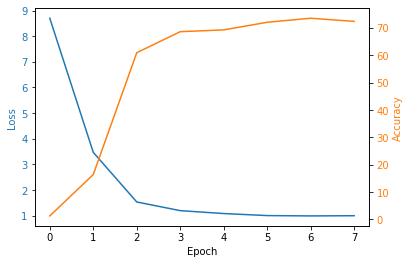

loss: 0.688261  [    0/30000] epoch: 8
loss: 0.501005  [ 3200/30000] epoch: 8
loss: 0.487407  [ 6400/30000] epoch: 8
loss: 0.202827  [ 9600/30000] epoch: 8
loss: 0.131655  [12800/30000] epoch: 8
loss: 0.220964  [16000/30000] epoch: 8
loss: 1.436015  [19200/30000] epoch: 8
loss: 0.338536  [22400/30000] epoch: 8
loss: 0.693107  [25600/30000] epoch: 8
loss: 0.654842  [28800/30000] epoch: 8
Epoch: 8
Test Error: 
 Accuracy: 73.3%, Avg loss: 1.026331 



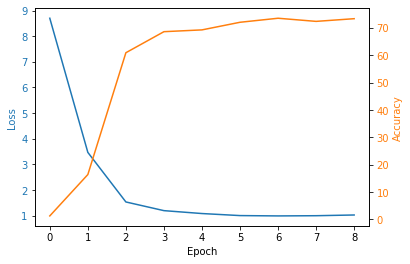

loss: 0.190974  [    0/30000] epoch: 9
loss: 0.678902  [ 3200/30000] epoch: 9
loss: 0.399748  [ 6400/30000] epoch: 9
loss: 0.297418  [ 9600/30000] epoch: 9
loss: 0.277574  [12800/30000] epoch: 9
loss: 0.438568  [16000/30000] epoch: 9
loss: 0.348070  [19200/30000] epoch: 9
loss: 0.729626  [22400/30000] epoch: 9
loss: 0.309510  [25600/30000] epoch: 9
loss: 0.242286  [28800/30000] epoch: 9
Epoch: 9
Test Error: 
 Accuracy: 73.0%, Avg loss: 1.001732 



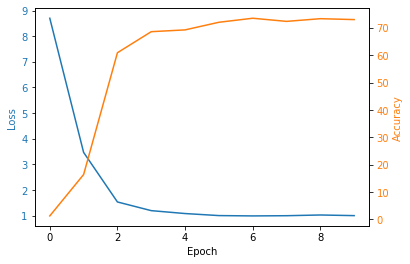

loss: 0.308475  [    0/30000] epoch: 10
loss: 0.220375  [ 3200/30000] epoch: 10
loss: 0.392568  [ 6400/30000] epoch: 10
loss: 0.057736  [ 9600/30000] epoch: 10
loss: 0.272358  [12800/30000] epoch: 10
loss: 0.110339  [16000/30000] epoch: 10
loss: 0.323772  [19200/30000] epoch: 10
loss: 0.318149  [22400/30000] epoch: 10
loss: 0.401209  [25600/30000] epoch: 10
loss: 0.467209  [28800/30000] epoch: 10
Epoch: 10
Test Error: 
 Accuracy: 73.8%, Avg loss: 0.992401 



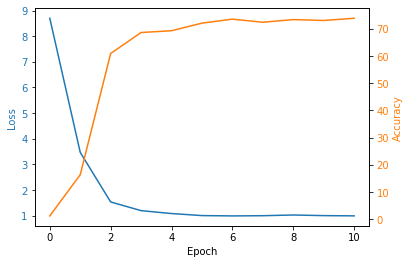

In [11]:
stats = train_loop(trainloader, valloader, beit, criterion, optimizer, 
                   labels, img_dir, feature_extractor)

In [12]:
df_stats = pd.DataFrame(stats)
df_stats.to_csv("../../stats_BEiT_data_aug.csv")

In [15]:
# PATH = './transfered_beit.pth'
# torch.save(beit.state_dict(), PATH)

beit.load_state_dict(torch.load("../../beit_data_augmented.pth"))
beit.to(device)

In [ ]:
test_results = {"img_name" : [], "label": []}

for file_name, image in tqdm(testloader):
    X = image.to(device)
    pred = beit(X)["logits"].argmax(1)
    
    test_results["img_name"] += file_name
    test_results["label"] += [int(i) for i in pred.cpu()]

In [21]:
test_df = pd.DataFrame(test_results)

test_df.head()

,img_name,label
0,test_1.jpg,15
1,test_10.jpg,45
2,test_100.jpg,34
3,test_1000.jpg,29
4,test_1001.jpg,10


In [22]:
test_df.to_csv("./submission_kfold_weight_decay.csv", index=False)